In [1]:
import sys
sys.path.append('.')



In [2]:
import os
import math
import numpy as np
from tqdm import tqdm
## TODO: auto install sklearn or write our own standarscaler
from sklearn.preprocessing import StandardScaler

import networkx as nx
import matplotlib.pyplot as plt



class DDN:
    def __init__(self):
        print("DNN package")
    
    def readGeneName(self, filename):
        with open(filename, 'r') as file:
            genename = file.read().split('\n')
        while len(genename) > 0 and genename[-1] == '':
            genename.pop()
        return genename
    
    def readGeneData(self, filename):
        genedata = np.loadtxt(filename)
        genedata = genedata.transpose()
        return genedata
    
    def standardizeGeneData(self, genedata, scaler='rms', zero_mean=True):
        # sample standardization : z = (x - u) / s
        
        standarddata = np.zeros(genedata.shape)
        for i in range(genedata.shape[1]):
            # mean value
            u = np.mean(genedata[:, i]) if not zero_mean else 0
            
            if scaler == 'std':
                # standard deviation
                s = np.std(genedata[:, i])
            elif scaler == 'rms':
                # root mean square
                s = np.sqrt(np.mean(np.square(genedata[:, i])))
            else:
                s = 1
            
            standarddata[:, i] = (genedata[:, i] - u) / s
        
        return standarddata
    
    def concatenateGeneData(self, controldata, casedata, method='diag'):
        if method == 'row':
            return np.concatenate((controldata, casedata), axis=0)
        elif method == 'col':
            return np.concatenate((controldata, casedata), axis=1)
        elif method == 'diag':
            return np.concatenate((np.concatenate((controldata, casedata * 0), axis=0), 
                                   np.concatenate((controldata * 0 ,casedata), axis=0)), axis=1)
        else:
            return []
    
    def solve2d(self, rho1, rho2, lambda1, lambda2):
        """
        description
        
        input
        output:
        cite: 
        
        """
        
        # initialize output
        area_index = 0
        beta1 = 0
        beta2 = 0
        
        if (rho2 <= (rho1 + 2*lambda2) and rho2 >= (rho2 - 2*lambda2) and rho2 >= (2*lambda1 - rho1)):
            area_index = 1
            beta1 = (rho1 + rho2)/2 - lambda1
            beta2 = (rho1 + rho2)/2 - lambda1
        if (rho2 > (rho1 + 2*lambda2) and rho1 >= (lambda1 - lambda2)):
            area_index = 2
            beta1 = rho1 - lambda1 + lambda2
            beta2 = rho2 - lambda1 - lambda2
        if (rho1 < (lambda1 - lambda2) and rho1 >= -(lambda1 + lambda2) and rho2 >= (lambda1 + lambda2)):
            area_index = 3
            beta1 = 0
            beta2 = rho2 - lambda1 - lambda2
        if (rho1 < -(lambda1 + lambda2) and rho2 >= (lambda1 + lambda2)):
            area_index = 4
            beta1 = rho1 + lambda1 + lambda2
            beta2 = rho2 - lambda1 - lambda2
        if (rho1 < -(lambda1 + lambda2) and rho2 < (lambda1 + lambda2) and rho2 >= -(lambda1 + lambda2)):
            area_index = 5
            beta1 = rho1 + lambda1 + lambda2
            beta2 = 0
        if (rho2 < -(lambda1 - lambda2) and rho2 >= (rho1 + 2*lambda2)):
            area_index = 6
            beta1 = rho1 + lambda1 + lambda2
            beta2 = rho2 + lambda1 - lambda2
        if (rho2 >= (rho1 - 2*lambda2) and rho2 < (rho1 + 2*lambda2) and rho2 <= (-2*lambda1 - rho1)):
            area_index = 7
            beta1 = (rho1 + rho2)/2 + lambda1
            beta2 = (rho1 + rho2)/2 + lambda1
        if (rho2 < (rho1 - 2*lambda2) and rho1 <= -(lambda1 - lambda2)):
            area_index = 8
            beta1 = rho1 + lambda1 - lambda2
            beta2 = rho2 + lambda1 + lambda2
        if (rho1 <= (lambda1 + lambda2) and rho1 >= -(lambda1 - lambda2) and rho2 <= -(lambda1 + lambda2)):
            area_index = 9
            beta1 = 0
            beta2 = rho2 + lambda1 + lambda2
        if (rho1 > (lambda1 + lambda2) and rho2 <= -(lambda1 + lambda2)):
            area_index = 10
            beta1 = rho1 - lambda1 - lambda2
            beta2 = rho2 + lambda1 + lambda2
        if (rho2 > -(lambda1 + lambda2) and rho2 <= (lambda1 - lambda2) and rho1 >= (lambda1 + lambda2)):
            area_index = 11
            beta1 = rho1 - lambda1 - lambda2
            beta2 = 0
        if (rho2 > (lambda1 - lambda2) and rho2 < (rho1 - 2*lambda2)):
            area_index = 12
            beta1 = rho1 - lambda1 - lambda2
            beta2 = rho2 - lambda1 + lambda2
        
        return [beta1, beta2]
    
    def bcdResi(self, X1, X2, CurrIdx, lambda1, lambda2, threshold, max_iter):
        if (X1.shape[1] != X2.shape[1]):
            return []
        
        p = X1.shape[1]
        n1 = X1.shape[0]
        n2 = X2.shape[0]
        beta1 = np.zeros(p)
        beta2 = np.zeros(p)
        
        y1_resi = X1[:, CurrIdx]
        y2_resi = X2[:, CurrIdx]
        
        r = 0
        k_last = CurrIdx
        while True:
            beta1_old = np.copy(beta1)
            beta2_old = np.copy(beta2)
            
            for i in range(p):
                if i == CurrIdx:
                    continue
                
                r = r + 1
                k = i
                
                y1_resi = y1_resi - beta1[k_last] * X1[:, k_last] + beta1[k] * X1[:, k]
                y2_resi = y2_resi - beta2[k_last] * X2[:, k_last] + beta2[k] * X2[:, k]
                rho1 = np.sum(y1_resi * X1[:, k]) / n1
                rho2 = np.sum(y2_resi * X2[:, k]) / n2
                
                beta2d = self.solve2d(rho1, rho2, lambda1, lambda2)
                beta1[k] = beta2d[0]
                beta2[k] = beta2d[1]
                
                k_last = k
            
            betaerr = np.mean(np.abs(np.concatenate([beta1 - beta1_old, beta2 - beta2_old])))
            if (betaerr < threshold) or (r > max_iter):
                break
        
        beta = np.concatenate([beta1, beta2])
        return beta
    
    def generateDifferentialNetwork(self, case_data, control_data, genename, lambda1=0.30, lambda2=0.10, threshold=1e-6, max_iter=1e4):
        # feature size (gene size)
        p = control_data.shape[1]
        
        # sample size
        n1 = control_data.shape[0]
        n2 = case_data.shape[0]
        
        # start calculations
        diffedges = {}
        for gene in tqdm(range(p)):
            # choose one gene as target
            y = self.concatenateGeneData(control_data[:, gene], case_data[:, gene], method='row')
            
            # choose other genes as feature
            idx = [i for i in range(p) if i != gene]
            X = self.concatenateGeneData(control_data[:, idx], case_data[:, idx], method='diag')
            
            # perform bcd algorithm
            beta = self.bcdResi(control_data, case_data, gene,lambda1, lambda2, threshold, max_iter)
            
            # reindex the features
            beta1 = np.array(beta[:p])
            beta2 = np.array(beta[p:])
            
            # construct neighbours under two conditions
            condition1 = [genename[i] for i in range(p) if beta1[i] != 0 and beta2[i] == 0]
            condition2 = [genename[i] for i in range(p) if beta2[i] != 0 and beta1[i] == 0]
            weight1 = [beta1[i] for i in range(p) if beta1[i] != 0 and beta2[i] == 0]
            weight2 = [beta2[i] for i in range(p) if beta2[i] != 0 and beta1[i] == 0]
            
            # update results
            for neighbors, weights, condition in zip([condition1, condition2], [weight1, weight2], ['condition1', 'condition2']):
                for neighbor, weight in zip(neighbors, weights):
                    tuple_diffedge = (min(genename[gene], neighbor), max(genename[gene], neighbor), condition)
                    diffedges.setdefault(tuple_diffedge, 0.0)
                    diffedges[tuple_diffedge] += weight
        
        diffedges = sorted([k + tuple([v]) for k, v in diffedges.items()])
        
        return diffedges
    
    def plotDifferentialNetwork(self, diffedges, maxalpha=1.0, minalpha=0.2):
        G = nx.Graph()
        color_condition = {'condition1': [1, 0, 0], 'condition2': [0, 0, 1]}
        maxbeta = max([beta for _, _, _, beta in diffedges])
        
        for gene1, gene2, condition, beta in diffedges:
            if condition in color_condition:
                alpha = beta / maxbeta * (maxalpha - minalpha) + minalpha
                color = list(1 - (1 - np.array(color_condition[condition])) * alpha)
                G.add_edge(gene1, gene2, color=color)
        
        pos = nx.circular_layout(G)
        edges = G.edges()
        edge_color = [G[u][v]['color'] for u, v in edges]
        node_size = [d * 200 for n, d in G.degree()]
        
        fig, ax = plt.subplots(figsize=(6, 6))
        nx.draw(G, pos=pos, node_color='lightblue', node_size=node_size, \
                edgelist=edges, edge_color=edge_color, width=3.5, \
                with_labels=True, font_size=16, font_weight='bold', font_color='magenta')
        
        ax.set_xlim((-1.2, +1.2))
        ax.set_ylim(ax.get_xlim())
        ax.set_title(''.join([
            'DDN Network\n', 
            '\n', 
            'condition #1: red edge\n', 
            'condition #2: blue edge'
        ]))
        plt.show()

    
    def printDifferentialNetwork(self, diffedges, filename=''):
        if len(filename) == 0:
            for gene, neighbor, condition, weight in diffedges:
                print(f"{gene},{neighbor},{condition},{weight}")
        else:
            with open(filename, 'w') as file:
                for gene, neighbor, condition, weight in diffedges:
                    file.write(f"{gene},{neighbor},{condition},{weight}\r")
    
    def DDNPipline(self, case_data_file, control_data_file, gene_name_file, output_file='', lambda1=0.30, lambda2=0.10):
        # import case data
        casedata = self.readGeneData(case_data_file)
        
        # import control data
        controldata = self.readGeneData(control_data_file)
        
        # import gene name
        genename = self.readGeneName(gene_name_file)
        
        # feature size must be equivalent
        assert(casedata.shape[1] == controldata.shape[1])
        
        # feature standardization
        case_standard = self.standardizeGeneData(casedata)
        control_standard = self.standardizeGeneData(controldata)
        
        # generate differential network
        diffedges = self.generateDifferentialNetwork(case_standard, control_standard, genename, lambda1, lambda2)
        
        # print differential network
        self.printDifferentialNetwork(diffedges, output_file)
        
        return diffedges
    
    def DDNBatchPipline(self, path='.', \
                        case_data_suffix='_case.txt', \
                        control_data_suffix='_control.txt', \
                        gene_name_suffix='_genename.txt', \
                        output_suffix='_differential_network.csv', \
                        lambda1=0.30, lambda2=0.10):
        idx = 0
        for file in os.listdir(path):
            if file.endswith(gene_name_suffix):
                gene_name_file = os.path.join(path, file)
                
                prefix = file[:-len(gene_name_suffix)]
                case_data_file = os.path.join(path, prefix+case_data_suffix)
                control_data_file = os.path.join(path, prefix+control_data_suffix)
                output_file = os.path.join(path, prefix+output_suffix)
                
                if os.path.exists(case_data_file) and os.path.exists(control_data_file):
                    self.DDNPipline(case_data_file, control_data_file, \
                                    gene_name_file, output_file, lambda1, lambda2)
                    
                    idx += 1
                    print(f"Dataset#{idx} : {prefix}    successfully processed!")
                
        return




In [3]:
%%time

ddn = DDN()
neighbors = ddn.DDNPipline(case_data_file='dataset_syntren_case.txt', \
                           control_data_file='dataset_syntren_control.txt', \
                           gene_name_file='dataset_syntren_genename.txt', \
                           output_file='output_syntren1.csv', \
                           lambda1=0.2, lambda2=0.03)
neighbors

DNN package


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.14it/s]

CPU times: total: 484 ms
Wall time: 1.56 s


[('ACE2', 'CAF4', 'condition1', 0.0026189833300861998),
 ('ACE2', 'SNF6', 'condition1', 0.16826121383895964),
 ('CDC10', 'FLO1', 'condition1', 0.010033889898116072),
 ('CDC11', 'FLO1', 'condition1', 0.04920953625052807),
 ('CLB5', 'MBP1_SWI6', 'condition2', 0.4028074875897196),
 ('CLB6', 'PHO2', 'condition1', 0.36516909229621586),
 ('FLO1', 'PHO2', 'condition2', 0.24800400317146373),
 ('FLO10', 'MBP1_SWI6', 'condition1', 0.21263456695541738),
 ('FLO10', 'PHO2', 'condition2', 0.3667958573859389),
 ('MBP1_SWI6', 'TRP4', 'condition1', 0.16532679648861023)]

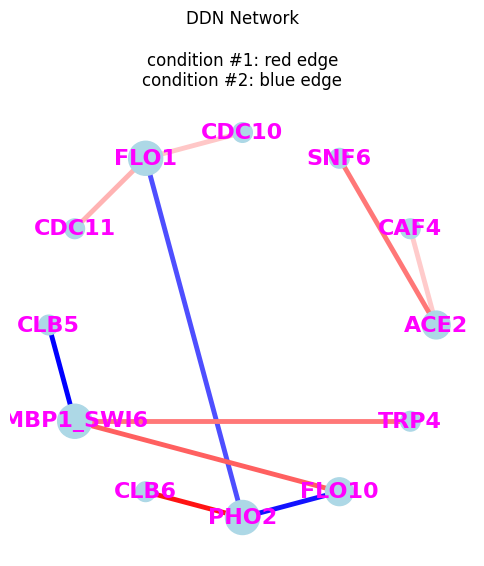

In [4]:
ddn.plotDifferentialNetwork(neighbors)